In [8]:
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [9]:

# Function to load data from multiple .pkl files
def load_data_from_directory(directory):
    X_data, y_data = [], []
    for file in os.listdir(directory):
        if file.endswith(".pkl"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                X_data.append(data['X'])
                y_data.append(data['y'])
    return np.array(X_data), np.array(y_data)

In [10]:


# Load data from train and test directories
train_dir = './preprocess/SLEEP_data/cassette_processed/train'
test_dir = './preprocess/SLEEP_data/cassette_processed/test'

X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# If the test set is empty, create it from a portion of the training data
if len(X_test) == 0 or len(y_test) == 0:
    print("Test set is empty. Splitting some data from the training set to use as the test set.")
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Normalize the data
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# Create a mapping for class modification
class_mapping = {
    'e': None,      # Class 'e' will be removed
    '1': 'N1',      # Map class '1' to 'N1'
    '2': 'N2',      # Map class '2' to 'N2'
    'W': 'Wake',    # Map class 'W' to 'Wake'
    'R': 'REM',     # Map class 'R' to 'REM'
    '3': 'N3',      # Merge class '3' into 'N3'
    '4': 'N3',      # Merge class '4' into 'N3'
}

# Modify the labels according to the mapping
def modify_labels(y):
    return np.array([class_mapping.get(label, label) for label in y])

y_train_modified = modify_labels(y_train)
y_test_modified = modify_labels(y_test)

 
train_mask = y_train_modified != None  # Mask for removing class 'e'
test_mask = y_test_modified != None     # Mask for removing class 'e'

 
X_train = X_train[train_mask]
y_train_modified = y_train_modified[train_mask]

X_test = X_test[test_mask]
y_test = y_test[test_mask]

 
all_labels_modified = np.concatenate((y_train_modified, y_test_modified))

 
label_encoder = LabelEncoder()
label_encoder.fit(all_labels_modified)  # Fit on the combined modified labels

# Encode the labels
y_train_encoded = label_encoder.transform(y_train_modified)
y_test_encoded = label_encoder.transform(y_test_modified)

 
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten the input for Neural Network
X_test = X_test.reshape(X_test.shape[0], -1)

 
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

 


In [11]:
model = keras.Sequential([
    layers.Input(shape=(X_train_resampled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(label_encoder.classes_), activation='softmax') 
])

 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

 
history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6295 - loss: 1.0031 - val_accuracy: 0.0483 - val_loss: 3.6369
Epoch 2/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9257 - loss: 0.2467 - val_accuracy: 0.0498 - val_loss: 2.2972
Epoch 3/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9594 - loss: 0.1338 - val_accuracy: 0.1015 - val_loss: 1.6936
Epoch 4/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9663 - loss: 0.1069 - val_accuracy: 0.2059 - val_loss: 1.3619
Epoch 5/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9772 - loss: 0.0907 - val_accuracy: 0.3635 - val_loss: 1.1815
Epoch 6/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9749 - loss: 0.0887 - val_accuracy: 0.5616 - val_loss: 0.9101
Epoch 7/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9811 - loss: 0.0648 - val_accuracy: 0.8603 - val_loss: 0.6071
Epoch 8/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9887 - loss: 0.0444 - val_accu

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Shape of y_test_encoded: (5558,), Shape of y_pred: (5558,)
Shape of X_test: (5558, 6000), Shape of y_test_modified: (5558,)
Accuracy: 82.37%


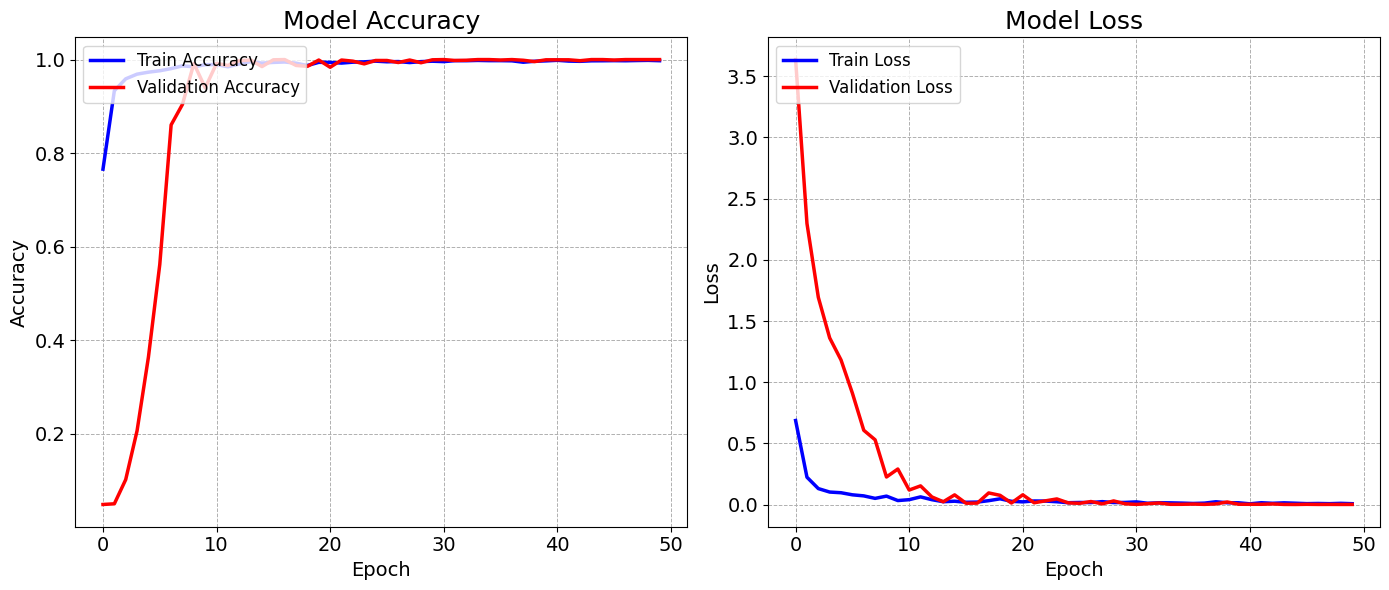

In [15]:
# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Print shapes for debugging
print(f'Shape of y_test_encoded: {y_test_encoded.shape}, Shape of y_pred: {y_pred.shape}')
print(f'Shape of X_test: {X_test.shape}, Shape of y_test_modified: {y_test_modified.shape}')

# Calculate accuracy only if shapes match
if y_test_encoded.shape[0] == y_pred.shape[0]:
    accuracy = accuracy_score(y_test_encoded, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
else:
    print("Mismatch in lengths: Cannot calculate accuracy.")

# Plot accuracy and loss over epochs
plt.figure(figsize=(14, 6))

# Line width for plots
line_width = 2.5

# Font sizes for titles, labels, legends
title_fontsize = 18
label_fontsize = 14
legend_fontsize = 12

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=line_width, color='b')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=line_width, color='r')
plt.title('Model Accuracy', fontsize=title_fontsize)
plt.ylabel('Accuracy', fontsize=label_fontsize)
plt.xlabel('Epoch', fontsize=label_fontsize)
plt.legend(loc='upper left', fontsize=legend_fontsize)
plt.grid(True, linestyle='--', linewidth=0.7)
plt.tick_params(axis='both', which='major', labelsize=label_fontsize)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=line_width, color='b')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=line_width, color='r')
plt.title('Model Loss', fontsize=title_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)
plt.xlabel('Epoch', fontsize=label_fontsize)
plt.legend(loc='upper left', fontsize=legend_fontsize)
plt.grid(True, linestyle='--', linewidth=0.7)
plt.tick_params(axis='both', which='major', labelsize=label_fontsize)

# Adjust layout
plt.tight_layout()
plt.show()

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


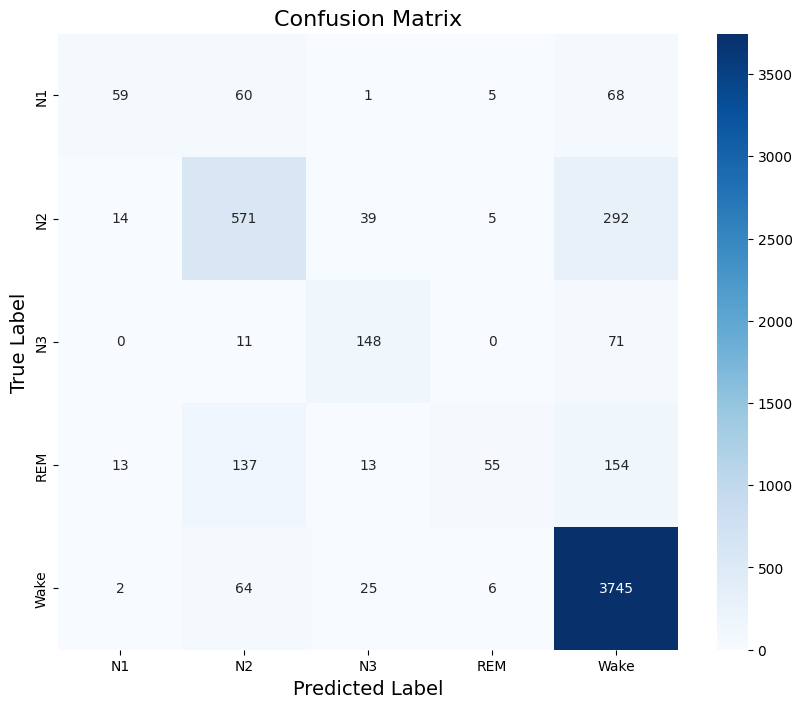

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [17]:
# %% [Plot confusion matrix]
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Ensure the lengths match for evaluation
min_len = min(len(y_test_encoded), len(y_pred))
y_test_encoded, y_pred = y_test_encoded[:min_len], y_pred[:min_len]

# Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

# %% [Plot training & validation accuracy and loss]
plt.figure(figsize=(14, 6))

 

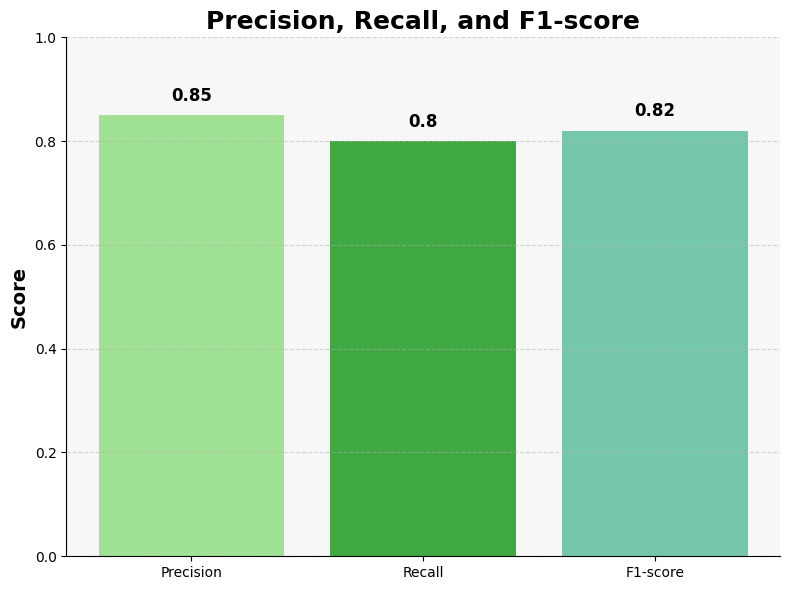

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Sample metrics (assuming these are calculated)
precision = 0.85  # Example values for demonstration
recall = 0.80
f1 = 0.82
metrics = [precision, recall, f1]
metric_names = ['Precision', 'Recall', 'F1-score']

# Specify a modern color pattern
colors = ['#98df8a', '#2ca02c', '#66c2a5']  # Light green, Dark green, Aqua green

# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(metric_names, metrics, color=colors, linewidth=0)

# Adding shadow to the bars for a modern look
for bar in bars:
    bar.set_linewidth(0)  # No edges
    bar.set_alpha(0.9)    # Slight transparency
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, round(bar.get_height(), 2), 
             ha='center', va='bottom', fontsize=12, color='black', weight='bold')

# Set title and labels with modern font style
plt.title('Precision, Recall, and F1-score', fontsize=18, weight='bold', family='sans-serif')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.ylabel('Score', fontsize=14, weight='bold', family='sans-serif')

# Improve layout and show the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add a subtle grid for better readability

# Customize the background for a modern feel
plt.gca().set_facecolor('#f7f7f7')  # Light grey background
plt.gca().spines['top'].set_visible(False)  # Hide top spine
plt.gca().spines['right'].set_visible(False)  # Hide right spine

plt.show()


# machine learning section

### Radom Forest


Random Forest Classifier Metrics:
Accuracy: 0.84
Weighted Precision: 0.85
Weighted Recall: 0.84
Weighted F1 Score: 0.82
Macro Precision: 0.90
Macro Recall: 0.56
Macro F1 Score: 0.64

Classification Report:
              precision    recall  f1-score   support

          N1       0.98      0.29      0.45       193
          N2       0.67      0.63      0.65       921
          N3       1.00      0.59      0.74       230
         REM       0.96      0.28      0.43       372
        Wake       0.86      0.99      0.92      3842

    accuracy                           0.84      5558
   macro avg       0.90      0.56      0.64      5558
weighted avg       0.85      0.84      0.82      5558



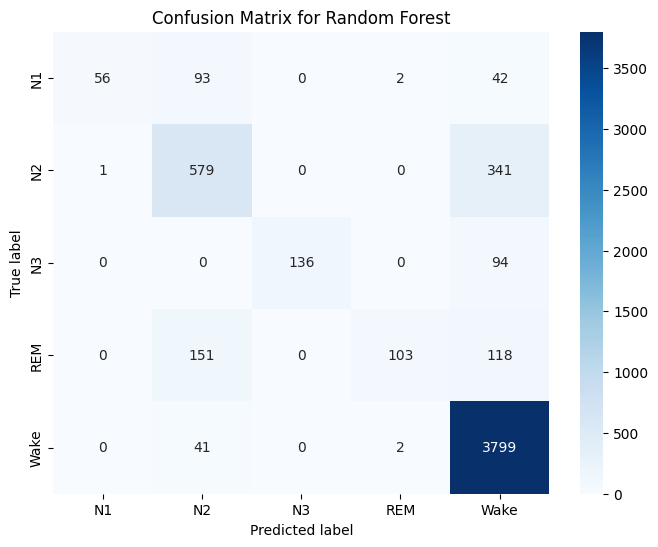

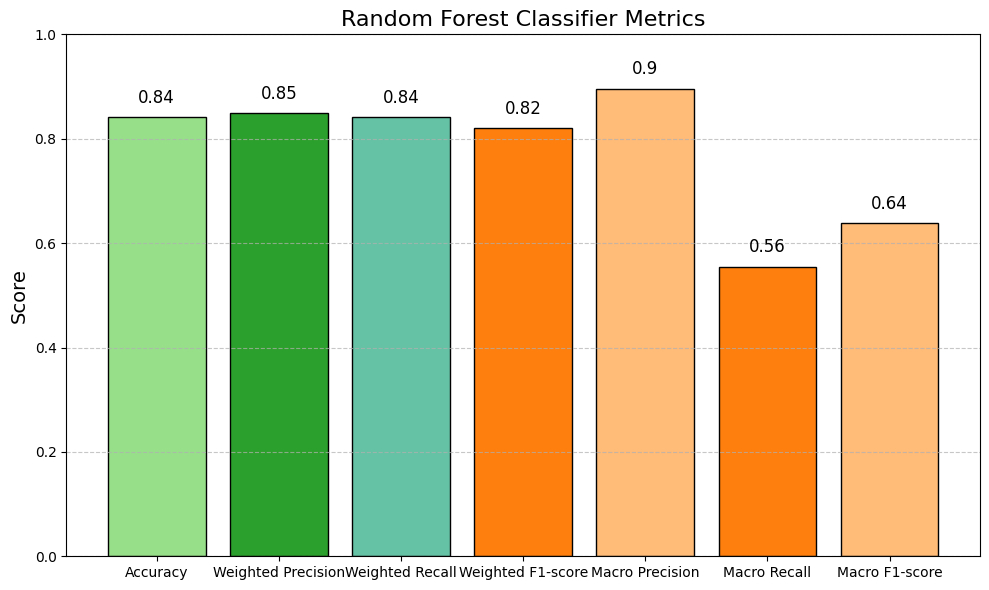

In [41]:
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# Load data from multiple .pkl files
def load_data_from_directory(directory):
    X_data, y_data = [], []
    for file in os.listdir(directory):
        if file.endswith(".pkl"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                X_data.append(data['X'])
                y_data.append(data['y'])
    return np.array(X_data), np.array(y_data)

# Load data from train and test directories
train_dir = './preprocess/SLEEP_data/cassette_processed/train'
test_dir = './preprocess/SLEEP_data/cassette_processed/test'

X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# If the test set is empty, create it from a portion of the training data
if len(X_test) == 0 or len(y_test) == 0:
    print("Test set is empty. Splitting some data from the training set to use as the test set.")
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Normalize the data
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# Create a mapping for class modification
class_mapping = {
    'e': None,      # Class 'e' will be removed
    '1': 'N1',      # Map class '1' to 'N1'
    '2': 'N2',      # Map class '2' to 'N2'
    'W': 'Wake',    # Map class 'W' to 'Wake'
    'R': 'REM',     # Map class 'R' to 'REM'
    '3': 'N3',      # Merge class '3' into 'N3'
    '4': 'N3',      # Merge class '4' into 'N3'
}

# Modify the labels according to the mapping
def modify_labels(y):
    return np.array([class_mapping.get(label, label) for label in y])

y_train_modified = modify_labels(y_train)
y_test_modified = modify_labels(y_test)

# Remove instances of class 'e'
train_mask = y_train_modified != None  # Mask for removing class 'e'
test_mask = y_test_modified != None     # Mask for removing class 'e'

X_train = X_train[train_mask]
y_train_modified = y_train_modified[train_mask]

X_test = X_test[test_mask]
y_test_modified = y_test_modified[test_mask]

# Encode the labels
label_encoder = LabelEncoder()
all_labels_modified = np.concatenate((y_train_modified, y_test_modified))
label_encoder.fit(all_labels_modified)  # Fit on the combined modified labels

y_train_encoded = label_encoder.transform(y_train_modified)
y_test_encoded = label_encoder.transform(y_test_modified)

# Flatten the input for Random Forest
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Apply SMOTE for class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

# Calculate macro metrics
macro_precision = precision_score(y_test_encoded, y_pred, average='macro')
macro_recall = recall_score(y_test_encoded, y_pred, average='macro')
macro_f1 = f1_score(y_test_encoded, y_pred, average='macro')

# Store results in a dictionary for later use
rf_metrics = {
    'model_name': 'Random Forest',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'macro_precision': macro_precision,
    'macro_recall': macro_recall,
    'macro_f1_score': macro_f1,
    'classification_report': classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_),
    'confusion_matrix': confusion_matrix(y_test_encoded, y_pred)
}

# Print metrics
print("Random Forest Classifier Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1 Score: {f1:.2f}")
print(f"Macro Precision: {macro_precision:.2f}")
print(f"Macro Recall: {macro_recall:.2f}")
print(f"Macro F1 Score: {macro_f1:.2f}")
print("\nClassification Report:")
print(rf_metrics['classification_report'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Random Forest')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot metrics
metrics_names = ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1-score', 'Macro Precision', 'Macro Recall', 'Macro F1-score']
metrics_values = [accuracy, precision, recall, f1, macro_precision, macro_recall, macro_f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['#98df8a', '#2ca02c', '#66c2a5', '#ff7f0e', '#ffbb78', '#ff7f0e', '#ffbb78'], edgecolor='black')

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom', fontsize=12)

# Set title and labels
plt.title('Random Forest Classifier Metrics', fontsize=16)
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.ylabel('Score', fontsize=14)

# Improve layout and show the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability
plt.show()

# Now rf_metrics contains all the relevant data for the Random Forest model
# You can access it later as needed


In [ ]:

# Print metrics
print("Random Forest Classifier Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1 Score: {f1:.2f}")
print(f"Macro Precision: {macro_precision:.2f}")
print(f"Macro Recall: {macro_recall:.2f}")
print(f"Macro F1 Score: {macro_f1:.2f}")
print("\nClassification Report:")
print(rf_metrics['classification_report'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Random Forest')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot metrics
metrics_names = ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1-score', 'Macro Precision', 'Macro Recall', 'Macro F1-score']
metrics_values = [accuracy, precision, recall, f1, macro_precision, macro_recall, macro_f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['#98df8a', '#2ca02c', '#66c2a5', '#ff7f0e', '#ffbb78', '#ff7f0e', '#ffbb78'], edgecolor='black')

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom', fontsize=12)

# Set title and labels
plt.title('Random Forest Classifier Metrics', fontsize=16)
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.ylabel('Score', fontsize=14)

# Improve layout and show the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability
plt.show()

# Now rf_metrics contains all the relevant data for the Random Forest model
# You can access it later as needed

### access like this 
### print(rf_metrics['macro_precision'])   # Access macro precision
### print(rf_metrics['macro_recall'])      # Access macro recall
### print(rf_metrics['macro_f1_score'])    # Access macro F1 score


### ensemble learning

In [ ]:
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Load data from multiple .pkl files
def load_data_from_directory(directory):
    X_data, y_data = [], []
    for file in os.listdir(directory):
        if file.endswith(".pkl"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                X_data.append(data['X'])
                y_data.append(data['y'])
    return np.array(X_data), np.array(y_data)

# Load data from train and test directories
train_dir = './preprocess/SLEEP_data/cassette_processed/train'
test_dir = './preprocess/SLEEP_data/cassette_processed/test'

X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# If the test set is empty, create it from a portion of the training data
if len(X_test) == 0 or len(y_test) == 0:
    print("Test set is empty. Splitting some data from the training set to use as the test set.")
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Normalize the data
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# Create a mapping for class modification
class_mapping = {
    'e': None,      # Class 'e' will be removed
    '1': 'N1',      # Map class '1' to 'N1'
    '2': 'N2',      # Map class '2' to 'N2'
    'W': 'Wake',    # Map class 'W' to 'Wake'
    'R': 'REM',     # Map class 'R' to 'REM'
    '3': 'N3',      # Merge class '3' into 'N3'
    '4': 'N3',      # Merge class '4' into 'N3'
}

# Modify the labels according to the mapping
def modify_labels(y):
    return np.array([class_mapping.get(label, label) for label in y])

y_train_modified = modify_labels(y_train)
y_test_modified = modify_labels(y_test)

# Remove instances of class 'e'
train_mask = y_train_modified != None  # Mask for removing class 'e'
test_mask = y_test_modified != None     # Mask for removing class 'e'

X_train = X_train[train_mask]
y_train_modified = y_train_modified[train_mask]

X_test = X_test[test_mask]
y_test_modified = y_test_modified[test_mask]

# Encode the labels
label_encoder = LabelEncoder()
all_labels_modified = np.concatenate((y_train_modified, y_test_modified))
label_encoder.fit(all_labels_modified)  # Fit on the combined modified labels

y_train_encoded = label_encoder.transform(y_train_modified)
y_test_encoded = label_encoder.transform(y_test_modified)

# Flatten the input for classifiers
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Apply SMOTE for class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

# Define individual classifiers
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(probability=True, random_state=42)  # Enable probability estimates
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)

# Create an ensemble classifier using voting
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model), 
        ('svm', svm_model), 
        ('log_reg', log_reg_model)
    ],
    voting='soft'  # Use soft voting
)

# Train the ensemble model
ensemble_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = ensemble_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

# Calculate macro metrics
macro_precision = precision_score(y_test_encoded, y_pred, average='macro')
macro_recall = recall_score(y_test_encoded, y_pred, average='macro')
macro_f1 = f1_score(y_test_encoded, y_pred, average='macro')

# Store results in a dictionary for later use
ensemble_metrics = {
    'model_name': 'Ensemble Learning (Voting Classifier)',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'macro_precision': macro_precision,
    'macro_recall': macro_recall,
    'macro_f1_score': macro_f1,
    'classification_report': classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_),
    'confusion_matrix': confusion_matrix(y_test_encoded, y_pred)
}

# Print metrics
print("Ensemble Learning Classifier Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1 Score: {f1:.2f}")
print(f"Macro Precision: {macro_precision:.2f}")
print(f"Macro Recall: {macro_recall:.2f}")
print(f"Macro F1 Score: {macro_f1:.2f}")
print("\nClassification Report:")
print(ensemble_metrics['classification_report'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(ensemble_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Ensemble Learning')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot metrics
metrics_names = ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1-score', 'Macro Precision', 'Macro Recall', 'Macro F1-score']
metrics_values = [accuracy, precision, recall, f1, macro_precision, macro_recall, macro_f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['#98df8a', '#2ca02c', '#66c2a5', '#ff7f0e', '#ffbb78', '#ff7f0e', '#ffbb78'], edgecolor='black')

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom', fontsize=12)

# Set title and labels
plt.title('Ensemble Learning Classifier Metrics', fontsize=16)
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.ylabel('Score', fontsize=14)

# Improve layout and show the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability
plt.show()

# Now ensemble_metrics contains all the relevant data for the Ensemble model
# You can access it later as needed


### stacking ensemble learning

In [ ]:
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Load data from multiple .pkl files
def load_data_from_directory(directory):
    X_data, y_data = [], []
    for file in os.listdir(directory):
        if file.endswith(".pkl"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                X_data.append(data['X'])
                y_data.append(data['y'])
    return np.array(X_data), np.array(y_data)

# Load data from train and test directories
train_dir = './preprocess/SLEEP_data/cassette_processed/train'
test_dir = './preprocess/SLEEP_data/cassette_processed/test'

X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# If the test set is empty, create it from a portion of the training data
if len(X_test) == 0 or len(y_test) == 0:
    print("Test set is empty. Splitting some data from the training set to use as the test set.")
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Normalize the data
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# Create a mapping for class modification
class_mapping = {
    'e': None,      # Class 'e' will be removed
    '1': 'N1',      # Map class '1' to 'N1'
    '2': 'N2',      # Map class '2' to 'N2'
    'W': 'Wake',    # Map class 'W' to 'Wake'
    'R': 'REM',     # Map class 'R' to 'REM'
    '3': 'N3',      # Merge class '3' into 'N3'
    '4': 'N3',      # Merge class '4' into 'N3'
}

# Modify the labels according to the mapping
def modify_labels(y):
    return np.array([class_mapping.get(label, label) for label in y])

y_train_modified = modify_labels(y_train)
y_test_modified = modify_labels(y_test)

# Remove instances of class 'e'
train_mask = y_train_modified != None  # Mask for removing class 'e'
test_mask = y_test_modified != None     # Mask for removing class 'e'

X_train = X_train[train_mask]
y_train_modified = y_train_modified[train_mask]

X_test = X_test[test_mask]
y_test_modified = y_test_modified[test_mask]

# Encode the labels
label_encoder = LabelEncoder()
all_labels_modified = np.concatenate((y_train_modified, y_test_modified))
label_encoder.fit(all_labels_modified)  # Fit on the combined modified labels

y_train_encoded = label_encoder.transform(y_train_modified)
y_test_encoded = label_encoder.transform(y_test_modified)

# Flatten the input for classifiers
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Apply SMOTE for class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

# Define base classifiers
base_classifiers = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),  # Enable probability estimates
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42))
]

# Create a stacking ensemble classifier
stacking_model = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=LogisticRegression(),
    cv=5  # Use 5-fold cross-validation for the stacking
)

# Train the stacking model
stacking_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = stacking_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

# Calculate macro metrics
macro_precision = precision_score(y_test_encoded, y_pred, average='macro')
macro_recall = recall_score(y_test_encoded, y_pred, average='macro')
macro_f1 = f1_score(y_test_encoded, y_pred, average='macro')

# Store results in a dictionary for later use
stacking_metrics = {
    'model_name': 'Stacking Ensemble Classifier',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'macro_precision': macro_precision,
    'macro_recall': macro_recall,
    'macro_f1_score': macro_f1,
    'classification_report': classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_),
    'confusion_matrix': confusion_matrix(y_test_encoded, y_pred)
}

# Print metrics
print("Stacking Ensemble Classifier Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1 Score: {f1:.2f}")
print(f"Macro Precision: {macro_precision:.2f}")
print(f"Macro Recall: {macro_recall:.2f}")
print(f"Macro F1 Score: {macro_f1:.2f}")
print("\nClassification Report:")
print(stacking_metrics['classification_report'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(stacking_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Stacking Ensemble Classifier')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot metrics
metrics_names = ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1-score', 'Macro Precision', 'Macro Recall', 'Macro F1-score']
metrics_values = [accuracy, precision, recall, f1, macro_precision, macro_recall, macro_f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['#98df8a', '#2ca02c', '#66c2a5', '#ff7f0e', '#ffbb78', '#ff7f0e', '#ffbb78'], edgecolor='black')

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom', fontsize=12)

# Set title and labels
plt.title('Stacking Ensemble Classifier Metrics', fontsize=16)
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.ylabel('Score', fontsize=14)

# Improve layout and show the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability
plt.show()

# Now stacking_metrics contains all the relevant data for the Stacking Ensemble model
# You can access it later as needed


### KNN

In [ ]:
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import seaborn as sns

# Load data from multiple .pkl files
def load_data_from_directory(directory):
    X_data, y_data = [], []
    for file in os.listdir(directory):
        if file.endswith(".pkl"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                X_data.append(data['X'])
                y_data.append(data['y'])
    return np.array(X_data), np.array(y_data)

# Load data from train and test directories
train_dir = './preprocess/SLEEP_data/cassette_processed/train'
test_dir = './preprocess/SLEEP_data/cassette_processed/test'

X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# If the test set is empty, create it from a portion of the training data
if len(X_test) == 0 or len(y_test) == 0:
    print("Test set is empty. Splitting some data from the training set to use as the test set.")
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Normalize the data
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# Create a mapping for class modification
class_mapping = {
    'e': None,      # Class 'e' will be removed
    '1': 'N1',      # Map class '1' to 'N1'
    '2': 'N2',      # Map class '2' to 'N2'
    'W': 'Wake',    # Map class 'W' to 'Wake'
    'R': 'REM',     # Map class 'R' to 'REM'
    '3': 'N3',      # Merge class '3' into 'N3'
    '4': 'N3',      # Merge class '4' into 'N3'
}

# Modify the labels according to the mapping
def modify_labels(y):
    return np.array([class_mapping.get(label, label) for label in y])

y_train_modified = modify_labels(y_train)
y_test_modified = modify_labels(y_test)

# Remove instances of class 'e'
train_mask = y_train_modified != None  # Mask for removing class 'e'
test_mask = y_test_modified != None     # Mask for removing class 'e'

X_train = X_train[train_mask]
y_train_modified = y_train_modified[train_mask]

X_test = X_test[test_mask]
y_test_modified = y_test_modified[test_mask]

# Encode the labels
label_encoder = LabelEncoder()
all_labels_modified = np.concatenate((y_train_modified, y_test_modified))
label_encoder.fit(all_labels_modified)  # Fit on the combined modified labels

y_train_encoded = label_encoder.transform(y_train_modified)
y_test_encoded = label_encoder.transform(y_test_modified)

# Flatten the input for classifiers
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Apply SMOTE for class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

# Initialize and train KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)  # KNN with 5 neighbors
knn_model.fit(X_train_pca, y_train_resampled)

# Make predictions
y_pred = knn_model.predict(X_test_pca)

# Calculate metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

# Calculate macro metrics
macro_precision = precision_score(y_test_encoded, y_pred, average='macro')
macro_recall = recall_score(y_test_encoded, y_pred, average='macro')
macro_f1 = f1_score(y_test_encoded, y_pred, average='macro')

# Store results in a dictionary for later use
knn_metrics = {
    'model_name': 'K-Nearest Neighbors Classifier with PCA',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'macro_precision': macro_precision,
    'macro_recall': macro_recall,
    'macro_f1_score': macro_f1,
    'classification_report': classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_),
    'confusion_matrix': confusion_matrix(y_test_encoded, y_pred)
}

# Print metrics
print("K-Nearest Neighbors Classifier Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1 Score: {f1:.2f}")
print(f"Macro Precision: {macro_precision:.2f}")
print(f"Macro Recall: {macro_recall:.2f}")
print(f"Macro F1 Score: {macro_f1:.2f}")
print("\nClassification Report:")
print(knn_metrics['classification_report'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(knn_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for K-Nearest Neighbors Classifier')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot metrics
metrics_names = ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1-score', 'Macro Precision', 'Macro Recall', 'Macro F1-score']
metrics_values = [accuracy, precision, recall, f1, macro_precision, macro_recall, macro_f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['#98df8a', '#2ca02c', '#66c2a5', '#ff7f0e', '#ffbb78', '#ff7f0e', '#ffbb78'], edgecolor='black')

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom', fontsize=12)

# Set title and labels
plt.title('K-Nearest Neighbors Classifier Metrics', fontsize=16)
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.ylabel('Score', fontsize=14)

# Improve layout and show the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability
plt.show()

# Now knn_metrics contains all the relevant data for the KNN model
# You can access it later as needed


### Gradient Boosting Method

In [ ]:
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
import seaborn as sns

# Load data from multiple .pkl files
def load_data_from_directory(directory):
    X_data, y_data = [], []
    for file in os.listdir(directory):
        if file.endswith(".pkl"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                X_data.append(data['X'])
                y_data.append(data['y'])
    return np.array(X_data), np.array(y_data)

# Load data from train and test directories
train_dir = './preprocess/SLEEP_data/cassette_processed/train'
test_dir = './preprocess/SLEEP_data/cassette_processed/test'

X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# If the test set is empty, create it from a portion of the training data
if len(X_test) == 0 or len(y_test) == 0:
    print("Test set is empty. Splitting some data from the training set to use as the test set.")
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Normalize the data
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# Create a mapping for class modification
class_mapping = {
    'e': None,      # Class 'e' will be removed
    '1': 'N1',      # Map class '1' to 'N1'
    '2': 'N2',      # Map class '2' to 'N2'
    'W': 'Wake',    # Map class 'W' to 'Wake'
    'R': 'REM',     # Map class 'R' to 'REM'
    '3': 'N3',      # Merge class '3' into 'N3'
    '4': 'N3',      # Merge class '4' into 'N3'
}

# Modify the labels according to the mapping
def modify_labels(y):
    return np.array([class_mapping.get(label, label) for label in y])

y_train_modified = modify_labels(y_train)
y_test_modified = modify_labels(y_test)

# Remove instances of class 'e'
train_mask = y_train_modified != None  # Mask for removing class 'e'
test_mask = y_test_modified != None     # Mask for removing class 'e'

X_train = X_train[train_mask]
y_train_modified = y_train_modified[train_mask]

X_test = X_test[test_mask]
y_test_modified = y_test_modified[test_mask]

# Encode the labels
label_encoder = LabelEncoder()
all_labels_modified = np.concatenate((y_train_modified, y_test_modified))
label_encoder.fit(all_labels_modified)  # Fit on the combined modified labels

y_train_encoded = label_encoder.transform(y_train_modified)
y_test_encoded = label_encoder.transform(y_test_modified)

# Flatten the input for classifiers
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Apply SMOTE for class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

# Initialize and train XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_pca, y_train_resampled)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_pca)

# Calculate metrics for XGBoost
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
precision_xgb = precision_score(y_test_encoded, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test_encoded, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test_encoded, y_pred_xgb, average='weighted')

# Calculate macro metrics for XGBoost
macro_precision_xgb = precision_score(y_test_encoded, y_pred_xgb, average='macro')
macro_recall_xgb = recall_score(y_test_encoded, y_pred_xgb, average='macro')
macro_f1_xgb = f1_score(y_test_encoded, y_pred_xgb, average='macro')

# Store results for XGBoost in a dictionary
xgb_metrics = {
    'model_name': 'XGBoost Classifier with PCA',
    'accuracy': accuracy_xgb,
    'precision': precision_xgb,
    'recall': recall_xgb,
    'f1_score': f1_xgb,
    'macro_precision': macro_precision_xgb,
    'macro_recall': macro_recall_xgb,
    'macro_f1_score': macro_f1_xgb,
    'classification_report': classification_report(y_test_encoded, y_pred_xgb, target_names=label_encoder.classes_),
    'confusion_matrix': confusion_matrix(y_test_encoded, y_pred_xgb)
}

# Initialize and train AdaBoost classifier
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train_pca, y_train_resampled)

# Make predictions
y_pred_ada = ada_model.predict(X_test_pca)

# Calculate metrics for AdaBoost
accuracy_ada = accuracy_score(y_test_encoded, y_pred_ada)
precision_ada = precision_score(y_test_encoded, y_pred_ada, average='weighted')
recall_ada = recall_score(y_test_encoded, y_pred_ada, average='weighted')
f1_ada = f1_score(y_test_encoded, y_pred_ada, average='weighted')

# Calculate macro metrics for AdaBoost
macro_precision_ada = precision_score(y_test_encoded, y_pred_ada, average='macro')
macro_recall_ada = recall_score(y_test_encoded, y_pred_ada, average='macro')
macro_f1_ada = f1_score(y_test_encoded, y_pred_ada, average='macro')

# Store results for AdaBoost in a dictionary
ada_metrics = {
    'model_name': 'AdaBoost Classifier with PCA',
    'accuracy': accuracy_ada,
    'precision': precision_ada,
    'recall': recall_ada,
    'f1_score': f1_ada,
    'macro_precision': macro_precision_ada,
    'macro_recall': macro_recall_ada,
    'macro_f1_score': macro_f1_ada,
    'classification_report': classification_report(y_test_encoded, y_pred_ada, target_names=label_encoder.classes_),
    'confusion_matrix': confusion_matrix(y_test_encoded, y_pred_ada)
}

# Function to print metrics and plot confusion matrix
def print_metrics_and_plot(metrics, title):
    print(f"{title} Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print(f"Weighted Precision: {metrics['precision']:.2f}")
    print(f"Weighted Recall: {metrics['recall']:.2f}")
    print(f"Weighted F1 Score: {metrics['f1_score']:.2f}")
    print(f"Macro Precision: {metrics['macro_precision']:.2f}")
    print(f"Macro Recall: {metrics['macro_recall']:.2f}")
    print(f"Macro F1 Score: {metrics['macro_f1_score']:.2f}")
    print("\nClassification Report:")
    print(metrics['classification_report'])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {title}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Plot metrics
    metrics_names = ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1-score', 'Macro Precision', 'Macro Recall', 'Macro F1-score']
    metrics_values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['macro_precision'], metrics['macro_recall'], metrics['macro_f1_score']]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics_names, metrics_values, color=['#98df8a', '#2ca02c', '#66c2a5', '#ff7f0e', '#ffbb78', '#ff7f0e', '#ffbb78'], edgecolor='black')

    # Add labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom', fontsize=12)

    # Set title and labels
    plt.title(f'{title} Metrics', fontsize=16)
    plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
    plt.ylabel('Score', fontsize=14)

    # Improve layout and show the plot
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability
    plt.show()

# Print metrics and plot for XGBoost
print_metrics_and_plot(xgb_metrics, "XGBoost Classifier")

# Print metrics and plot for AdaBoost
print_metrics_and_plot(ada_metrics, "AdaBoost Classifier")
